In [29]:

import pandas as pd
from pathlib import Path
import json
from geopy.geocoders import Nominatim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

pd.set_option('display.max_columns', 500)

In [2]:
files = list(Path("./predict-energy-behavior-of-prosumers/").glob("*.csv"))
for file in files:
    print(f"creates: {file.stem}")
    globals()[file.stem] = pd.read_csv(file)

creates: weather_station_to_county_mapping
creates: gas_prices
creates: historical_weather
creates: forecast_weather
creates: electricity_prices
creates: train
creates: client


In [26]:
f = open('./predict-energy-behavior-of-prosumers/county_id_to_name_map.json')
county_codes = json.load(f)

In [27]:
parsed_counties = {v.lower().rstrip("maa"): k for k, v in county_codes.items()}

In [6]:
name_mapping = {
    "valga": "valg",
    "põlva": "põlv",
    "jõgeva": "jõgev",
    "rapla": "rapl",
    "järva": "järv"
}

geoLoc = Nominatim(user_agent="GetLoc")

country2 = []

for i, coords in  tqdm(forecast_weather[["latitude", "longitude"]].drop_duplicates().iterrows()):
    
    lat, lon = coords["latitude"], coords["longitude"]       
    # passing the coordinates
    locname = geoLoc.reverse(f"{lat}, {lon}")   # lat, lon
    if locname is None: 
        country2.append('unknown')
    else: 
        location = locname.raw["address"]
        if location["country"] == "Eesti":
            county = location['county'].split()[0].lower()
            county = name_mapping.get(county, county)
            country2.append(county)
        else:
            country2.append('unknown')

112it [00:56,  1.97it/s]


In [7]:
# we're going to use aux as a basis dataframe to empalm the others dataframes

In [8]:
aux = historical_weather[['latitude', 'longitude']].drop_duplicates()

In [9]:
aux['country'] = country2

In [10]:
aux['country'] = aux['country'].map(parsed_counties)

In [11]:
aux

,latitude,longitude,country
0,57.6,21.7,12
1,57.6,22.2,12
2,57.6,22.7,12
3,57.6,23.2,10
4,57.6,23.7,12
...,...,...,...
107,59.7,26.2,5
108,59.7,26.7,5
109,59.7,27.2,12
110,59.7,27.7,12


In [12]:
new = pd.merge(historical_weather, aux, on = ['latitude', 'longitude'], how = 'inner')

In [13]:
new['country'] = new['country'].apply(eval)

In [14]:
aux = historical_weather.drop(columns=['datetime'])

names = aux.columns

In [15]:
historical_weather.shape

(1710800, 18)

In [16]:
average = new.groupby(['datetime', 'country'])[names].mean().reset_index()

In [17]:
average.sort_values(['country', 'datetime'], inplace = True)

In [19]:
h = average[average['country'] == 1]

In [33]:
h['datetime'] = pd.to_datetime(h['datetime'])

/tmp/ipykernel_16068/5482177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h['datetime'] = pd.to_datetime(h['datetime'])


In [34]:
h.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15275 entries, 0 to 244384
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   datetime                15275 non-null  datetime64[ns]
 1   country                 15275 non-null  int64         
 2   temperature             15275 non-null  float64       
 3   dewpoint                15275 non-null  float64       
 4   rain                    15275 non-null  float64       
 5   snowfall                15275 non-null  float64       
 6   surface_pressure        15275 non-null  float64       
 7   cloudcover_total        15275 non-null  float64       
 8   cloudcover_low          15275 non-null  float64       
 9   cloudcover_mid          15275 non-null  float64       
 10  cloudcover_high         15275 non-null  float64       
 11  windspeed_10m           15275 non-null  float64       
 12  winddirection_10m       15275 non-null  float64   

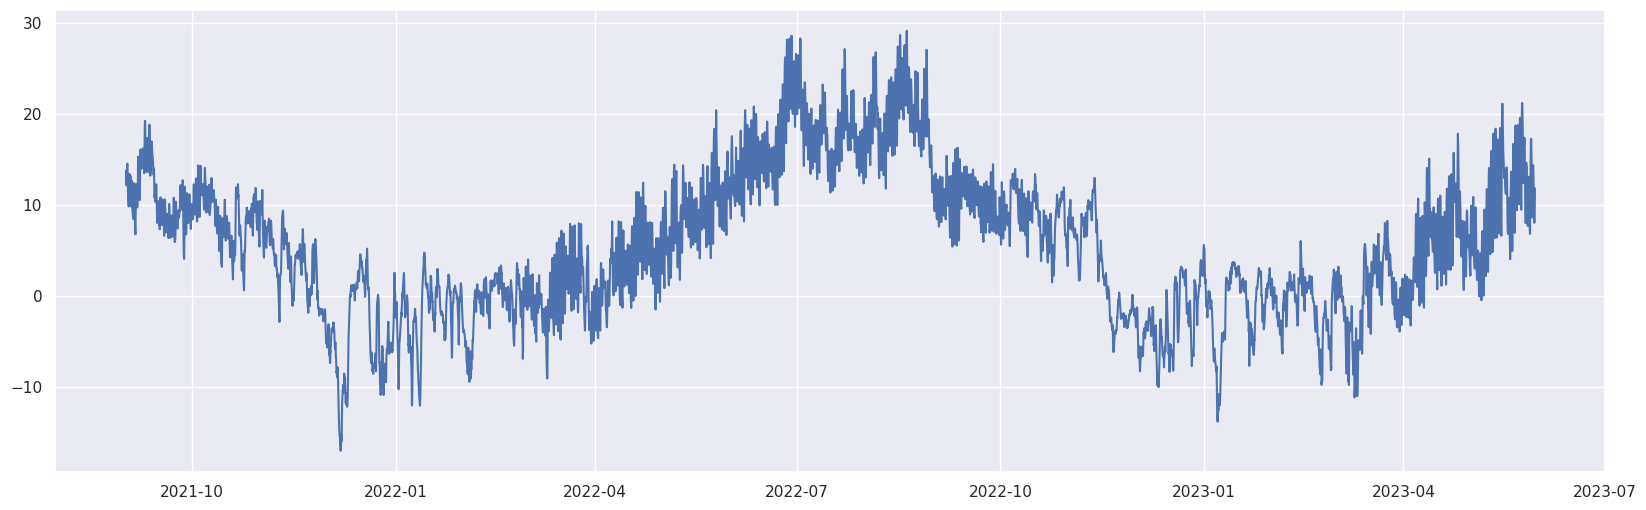

In [38]:
plt.figure(figsize=(20, 6))  
plt.plot(h['datetime'], h['temperature'])

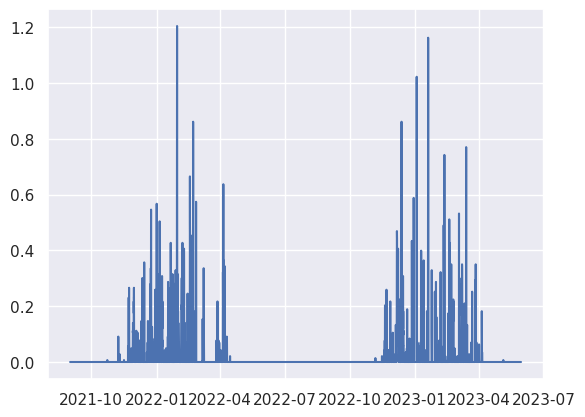

In [36]:
plt.plot(h['datetime'], h['snowfall'])

Text(0, 0.5, 'Frecuencia')

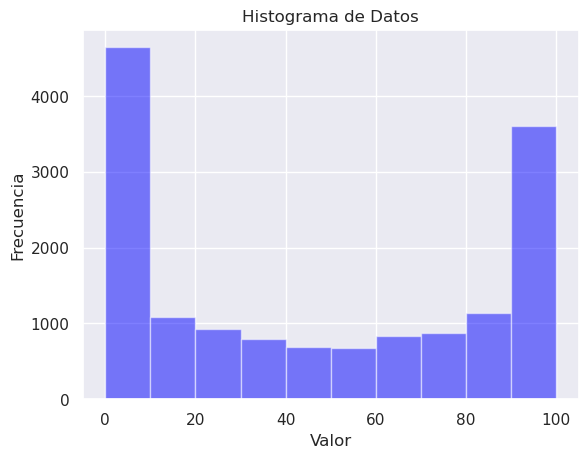

In [37]:
plt.hist(h['cloudcover_low'], bins=10, alpha=0.5, color='blue')
plt.title('Histograma de Datos')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')